# Problem Statement

Current benchmarks like SWE-bench and SWE-bench Verified evaluate agents on a diverse set of real-world engineering tasks. However, they lack any structured representation of the task space itself. As a result, these headline benchmarks function more as scoreboards than as frameworks for systematically guiding agent development. Without insight into how tasks are distributed or how they span the feature space, it becomes difficult to diagnose where and why agents succeed or fail, ultimately limiting the benchmark's utility for capability-driven progress.

# Research Question

Can we map the feature space of benchmark tasks using clustering techniques for mixed-type data, in order to better understand agent successes and failures? Can this structure then be used to both guide the development of specific agent capabilities and more accurately measure agent performance?

# The Datasets
This notebook focuses on the SWE-bench Verified dataset, a curated subset of 500 tasks drawn from the full SWE-bench benchmark. As mentioned above this subset was released by Open AI and consists of tasks selected and verified by humans to ensure that they are solvable by a LLM.

In addition to the benchmark tasks themselves, I have used the annotation dataset also provided by OpenAI. This dataset includes rich metadata for each task, such as:

- Task difficulty (as rated by annotators)

- Task difficulty decision - i.e., the extent to which the human raters agreed

- Estimated time to complete the task

- Specification quality (i.e., whether the task is under-specified)

- Failure analysis flags (e.g., whether the task had issues unrelated to agent quality)

- Freeform notes on each of these dimensions.

These annotated features enable a richer analysis of task structure and serve as a partial proxy for task complexity and ambiguity. They also provide weak labels that allow us to qualitatively validate the clusters i.e., to question whether certain clusters align with harder, more ambiguous, or more time-consuming tasks.

Together, these two datasets offer a rich, mixed-type data source that enables experimentation with a variety of clustering algorithms and methods.

# Supported Section: Data Exploration, K-Means Clustering and K-Prototypes
This notebook supports the text data exploration in the Datasets section of my thesis as well as the K-Means and K-Protoypes results in the Results section.

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from google.colab import files

# Analysing the Open AI Annotation Dataset

In [2]:
df_annotate = pd.read_csv("ensembled_annotations_public.csv")
df_annotate.shape

(1699, 14)

#### This dataset consistes on 1699 rows and 14 columns.


In [3]:
df_annotate.head()

,instance_id,underspecified,underspecified_notes,false_negative,false_negative_notes,other_major_issues,other_notes,difficulty,underspecified_decided_by,false_negative_decided_by,other_major_issues_decided_by,difficulty_decided_by,difficulty_ensemble_decision_procedure,filter_out
0,astropy__astropy-11693,1.0,The issue arises when attempting to plot an im...,3.0,"The test patch, checks that NoConvergence erro...",0.0,NaN,15 min - 1 hour,17,72,17,"[17, 72, 69]",majority,True
1,astropy__astropy-12544,0.0,The problem described in the issue is that whe...,3.0,"The parameter introduced is `mask_invalid`, wh...",0.0,NaN,1-4 hours,65,65,65,"[65, 71]",majority,True
2,astropy__astropy-12825,1.0,The issue is clear and steps to replicate it a...,2.0,The tests cover all solutions for both the sup...,0.0,NaN,1-4 hours,91,91,55,[12],median,True
3,astropy__astropy-12842,1.0,"Though, there are some external links were pro...",2.0,The tests are working but some perfectly reaso...,0.0,NaN,1-4 hours,87,87,87,"[90, 31]",majority,True
4,astropy__astropy-12880,1.0,"After upgrading from Astropy 4.2.1 to 5.0+, `B...",3.0,The test assumes a solution that involves allo...,0.0,NaN,<15 min fix,17,78,17,"[17, 78]",majority,True


In [4]:
print(df_annotate.columns)

Index(['instance_id', 'underspecified', 'underspecified_notes',
       'false_negative', 'false_negative_notes', 'other_major_issues',
       'other_notes', 'difficulty', 'underspecified_decided_by',
       'false_negative_decided_by', 'other_major_issues_decided_by',
       'difficulty_decided_by', 'difficulty_ensemble_decision_procedure',
       'filter_out'],
      dtype='object')


In [5]:
#Top values by field
summary=[]
for col in df_annotate.columns:
  col_type = df_annotate[col].dtype
  n_unique = df_annotate[col].nunique()
  top_vals = df_annotate[col].value_counts().head(2).to_dict()
  summary.append({
      "Variable":col,
      "Type":str(col_type),
      "Unique_values": n_unique,
      "Top_values": top_vals
  })
summary_df = pd.DataFrame(summary)
summary_df

,Variable,Type,Unique_values,Top_values
0,instance_id,object,1699,"{'sympy__sympy-24909': 1, 'astropy__astropy-11..."
1,underspecified,float64,4,"{1.0: 653, 2.0: 542}"
2,underspecified_notes,object,1697,{'The description must be self-contained. In a...
3,false_negative,float64,4,"{2.0: 558, 3.0: 481}"
4,false_negative_notes,object,1696,{'The description must be self-contained. In a...
5,other_major_issues,float64,2,"{0.0: 1564, 1.0: 135}"
6,other_notes,object,150,"{'No other issues with the task': 36, 'No issu..."
7,difficulty,object,4,"{'15 min - 1 hour': 906, '<15 min fix': 417}"
8,underspecified_decided_by,int64,92,"{7: 56, 57: 51}"
9,false_negative_decided_by,int64,90,"{7: 54, 18: 54}"


#### The top values already show us that most of the tasks in this subset take less than 1h to fix and are well specified (i.e, few are deemed level 3, which is totally underspeciifed!). The majority of annotators agreed on their characterisation of task difficulty, with the top result for the "difficulty_ensemble_Decision_procedure" field being "majority".

# SWE-Bench Verified Dataset

This section takes the SWE-Bench Verified set and merges it with the annotations dataset so as to make a decision on which features to include in the clustering.

In [6]:
#Merging the data with the annotations dataset
df=pd.read_csv("swe_bench_verified_test.csv")

df_merged = df.merge(df_annotate, on='instance_id', how='left')

In [7]:
df_merged.head()

,repo,instance_id,base_commit,patch,test_patch,problem_statement,hints_text,created_at,version,FAIL_TO_PASS,...,false_negative_notes,other_major_issues,other_notes,difficulty_y,underspecified_decided_by,false_negative_decided_by,other_major_issues_decided_by,difficulty_decided_by,difficulty_ensemble_decision_procedure,filter_out
0,astropy/astropy,astropy__astropy-12907,d16bfe05a744909de4b27f5875fe0d4ed41ce607,diff --git a/astropy/modeling/separable.py b/a...,diff --git a/astropy/modeling/tests/test_separ...,Modeling's `separability_matrix` does not comp...,NaN,2022-03-03T15:14:54Z,4.3,"[""astropy/modeling/tests/test_separable.py::te...",...,The goal of the test patch is to evaluate nest...,0.0,NaN,15 min - 1 hour,75,75,75,"[75, 28]",majority,False
1,astropy/astropy,astropy__astropy-13033,298ccb478e6bf092953bca67a3d29dc6c35f6752,diff --git a/astropy/timeseries/core.py b/astr...,diff --git a/astropy/timeseries/tests/test_sam...,TimeSeries: misleading exception when required...,The relevant code that produces the misleading...,2022-03-31T23:28:27Z,4.3,"[""astropy/timeseries/tests/test_sampled.py::te...",...,The error message is raised is particular to t...,0.0,NaN,15 min - 1 hour,61,61,13,"[13, 17]",majority,False
2,astropy/astropy,astropy__astropy-13236,6ed769d58d89380ebaa1ef52b300691eefda8928,diff --git a/astropy/table/table.py b/astropy/...,diff --git a/astropy/table/tests/test_mixin.py...,Consider removing auto-transform of structured...,@mhvk - I'm happy to do this PR if you think i...,2022-05-09T14:16:30Z,5.0,"[""astropy/table/tests/test_mixin.py::test_ndar...",...,1. Issue description wants the agent to remove...,0.0,NaN,15 min - 1 hour,71,71,71,[71],median,False
3,astropy/astropy,astropy__astropy-13398,6500928dc0e57be8f06d1162eacc3ba5e2eff692,diff --git a/astropy/coordinates/builtin_frame...,diff --git a/astropy/coordinates/tests/test_in...,A direct approach to ITRS to Observed transfor...,"cc @StuartLittlefair, @adrn, @eteq, @eerovaher...",2022-06-24T15:22:11Z,5.0,"[""astropy/coordinates/tests/test_intermediate_...",...,The tests are well scoped and cover all possib...,0.0,NaN,1-4 hours,12,12,12,"[12, 62]",majority,False
4,astropy/astropy,astropy__astropy-13453,19cc80471739bcb67b7e8099246b391c355023ee,diff --git a/astropy/io/ascii/html.py b/astrop...,diff --git a/astropy/io/ascii/tests/test_html....,ASCII table output to HTML does not support su...,Welcome to Astropy 👋 and thank you for your fi...,2022-07-14T10:04:40Z,5.0,"[""astropy/io/ascii/tests/test_html.py::test_wr...",...,The `test_write_table_formatted_columns` funct...,0.0,NaN,15 min - 1 hour,67,67,67,"[61, 28]",majority,False


In [8]:
#Dropping unecessary columns such as duplicate columns and columns that provide the index number of people who made a given decision
cols_to_drop = ["difficulty_y"] + [col for col in df_merged.columns if col.endswith('_decided_by')] + \
              ["filter_out"] + ["difficulty_ensemble_decision_procedure"] + \
               ["other_notes"] +["other_major_issues"] + ["instance_id"] +["created_at"]+["version"] + \
               ["environment_setup_commit"] + ["base_commit"] +["test_patch"]
df_cleaned = df_merged.drop(columns = cols_to_drop)
df_cleaned = df_cleaned.rename(columns = {"difficulty_x":"difficulty"})

In [9]:
df_cleaned["underspecified"].value_counts()

,count
underspecified,
1.0,262
0.0,238


###There is broadly an even split between underspecified and specified tasks

In [10]:
df_cleaned["difficulty"].value_counts()

,count
difficulty,
15 min - 1 hour,261
<15 min fix,194
1-4 hours,42
>4 hours,3


SWE-Bench verified is skewed towards simpler tasks.

In [11]:
df_cleaned["repo"].value_counts()

,count
repo,
django/django,231
sympy/sympy,75
sphinx-doc/sphinx,44
matplotlib/matplotlib,34
scikit-learn/scikit-learn,32
astropy/astropy,22
pydata/xarray,22
pytest-dev/pytest,19
pylint-dev/pylint,10


Tasks on SWE-Bench Verified are drawn from 12 Python repositories, with the main one being Djando followed by Sympy.

In [12]:
df_cleaned.head()

,repo,patch,problem_statement,hints_text,FAIL_TO_PASS,PASS_TO_PASS,difficulty,underspecified,underspecified_notes,false_negative,false_negative_notes
0,astropy/astropy,diff --git a/astropy/modeling/separable.py b/a...,Modeling's `separability_matrix` does not comp...,NaN,"[""astropy/modeling/tests/test_separable.py::te...","[""astropy/modeling/tests/test_separable.py::te...",15 min - 1 hour,1.0,"The issue description is clear, explaining tha...",0.0,The goal of the test patch is to evaluate nest...
1,astropy/astropy,diff --git a/astropy/timeseries/core.py b/astr...,TimeSeries: misleading exception when required...,The relevant code that produces the misleading...,"[""astropy/timeseries/tests/test_sampled.py::te...","[""astropy/timeseries/tests/test_sampled.py::te...",15 min - 1 hour,1.0,The issue's concern is well understood. The va...,1.0,The error message is raised is particular to t...
2,astropy/astropy,diff --git a/astropy/table/table.py b/astropy/...,Consider removing auto-transform of structured...,@mhvk - I'm happy to do this PR if you think i...,"[""astropy/table/tests/test_mixin.py::test_ndar...","[""astropy/table/tests/test_mixin.py::test_attr...",15 min - 1 hour,1.0,1. It is clearly suggested that automatic conv...,0.0,1. Issue description wants the agent to remove...
3,astropy/astropy,diff --git a/astropy/coordinates/builtin_frame...,A direct approach to ITRS to Observed transfor...,"cc @StuartLittlefair, @adrn, @eteq, @eerovaher...","[""astropy/coordinates/tests/test_intermediate_...","[""astropy/coordinates/tests/test_intermediate_...",1-4 hours,0.0,Issue description is well specified. It inform...,0.0,The tests are well scoped and cover all possib...
4,astropy/astropy,diff --git a/astropy/io/ascii/html.py b/astrop...,ASCII table output to HTML does not support su...,Welcome to Astropy 👋 and thank you for your fi...,"[""astropy/io/ascii/tests/test_html.py::test_wr...","[""astropy/io/ascii/tests/test_html.py::test_li...",15 min - 1 hour,0.0,The issue description is very clear and well-o...,0.0,The `test_write_table_formatted_columns` funct...


# Exploratory Data Analysis

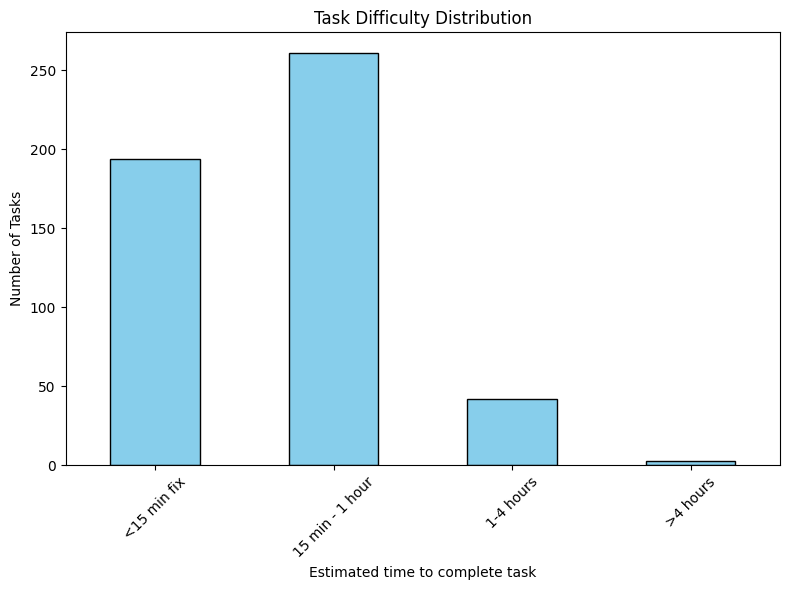

In [13]:
#Chart of task difficulty distribution, which is a measure of time spent on the assumption the engineer already knows the solution.

difficulty_order = ["<15 min fix", "15 min - 1 hour", "1-4 hours",">4 hours"]

df_cleaned["difficulty"]=pd.Categorical(
    df_cleaned["difficulty"],
    categories=difficulty_order,
    ordered=True
)

difficulty_counts = df_cleaned["difficulty"].value_counts().sort_index()

plt.figure(figsize=(8,6))
difficulty_counts.plot(kind="bar", color="skyblue", edgecolor = "black")
plt.xticks(rotation = 45)
plt.xlabel("Estimated time to complete task")
plt.ylabel("Number of Tasks")
plt.title("Task Difficulty Distribution")
plt.tight_layout()
plt.show()

The majority of tasks in this dataset can be solved in less than 1 hour. There is a long tail of tasks that take 1-4h and a very small number that take in excess of this.

This distribution suggest SWE-Bench Verified is heavily skewed toward structurally simpler tasks. It is important to remember that these difficulty ratings capture execution complexity rather than solution discovery effort, they assume the engineer already knows what to implement. This means the task distribution likely masks important capability distinctions required between agents, particularly in areas like problem comprehension and solution design.

# Feature Extraction From Patches

To prepare the dataset for clustering, I extract the structural features from each task's associated pull request using the PatchSet class from the unidiff Python library.

A patch here refers to a code change. PatchSet parses the unified diff format and allows for the extraction of a number of low-level structural signals from each patch.

The features extracted were:

- The number of files changed

- The number of hunks in a given code change (i.e., blocks of contiguous edits)

- The number of lines of code added

- The number of lines of code removed

These features serve as numerical proxies for task size and task complexity and provide a rough measure of how involved a code change is. This will be important later for mapping to agent capabilities like localisation (where in the code to make the edits) and planning (how many steps are needed).


These extracted features (and derived features) will be used as input to a baseline  K-Means clustering algorithm, where the number of clusters will be set to 6 and later optimised using a silhoutte score. This is really to form a baseline to compare against. The aim is to see whether clear clusters emerge based on code changes size/structure only and if these clusters align with known task properties like difficulty or ambiguity.

In [14]:
!pip install unidiff

from unidiff import PatchSet


In [18]:
#Function to extract basic numerical features from patch and compute derived features.
def extract_patch_features(patch_text: str) -> pd.Series:
    try:
        patch = PatchSet(patch_text)

        #Basic Features
        num_files = len(patch)
        num_hunks = sum(len(file) for file in patch)
        lines_added = sum(hunk.added for file in patch for hunk in file)
        lines_removed = sum(hunk.removed for file in patch for hunk in file)

        #----DERIVED FEATURES------
        #Code Churn
        total_lines_changed = lines_added + lines_removed

        #Change Ratio (log-transformed to handle outliers)
        change_ratio = np.log1p(lines_added) / (np.log1p(lines_removed) + 1)


        #Change Concentration
        changes_per_file = [
            sum(hunk.added + hunk.removed for hunk in file)
            for file in patch
        ]

        if changes_per_file:
            max_file_change = max(changes_per_file)
            change_concentration = max_file_change / (total_lines_changed + 1)
            change_spread = np.std(changes_per_file) / (np.mean(changes_per_file) + 1)
        else:
            max_file_change = 0
            change_concentration = 0
            change_spread = 0

        return pd.Series([
            num_files, num_hunks, lines_added, lines_removed,
            total_lines_changed, change_ratio,
            max_file_change, change_concentration, change_spread
        ])

    except Exception as e:
        return pd.Series([None] * 10)


target_columns = [
    "num_files", "num_hunks", "lines_added", "lines_removed",
    "total_lines_changed", "change_ratio",
    "max_file_change", "change_concentration","change_spread"
]


df_cleaned[target_columns] = df_cleaned["patch"].apply(extract_patch_features)


print(df_cleaned[target_columns].head())

   num_files  num_hunks  lines_added  lines_removed  total_lines_changed  \
0        1.0        1.0          1.0            1.0                  2.0   
1        1.0        2.0         11.0            3.0                 14.0   
2        1.0        1.0          0.0            7.0                  7.0   
3        4.0        8.0        202.0           13.0                215.0   
4        1.0        1.0          2.0            0.0                  2.0   

   change_ratio  max_file_change  change_concentration  change_spread  
0      0.409384              2.0              0.666667       0.000000  
1      1.041324             14.0              0.933333       0.000000  
2      0.000000              7.0              0.875000       0.000000  
3      1.460050            145.0              0.671296       1.016728  
4      1.098612              2.0              0.666667       0.000000  


In [19]:
#Summary statistics for the new features
print("Summary statistics for new features:")
print(df_cleaned[target_columns].describe())


#Looking at correlations with difficulty
print("\n\nCorrelation with difficulty:")
difficulty_map = {
    "<15 min fix": 0,
    "15 min - 1 hour": 1,
    "1-4 hours": 2,
    ">4 hours": 3
}
df_cleaned['difficulty_numeric'] = df_cleaned['difficulty'].map(difficulty_map)

#Selects numeric features for correlation
numeric_features = ['total_lines_changed',
                   'change_concentration', 'change_spread', 'max_file_change']

for feat in numeric_features:
    corr = df_cleaned[[feat, 'difficulty_numeric']].corr().iloc[0, 1]
    print(f"{feat}: {corr:.3f}")

#all numerical columns needed for clustering
numerical_cols = ["num_files", "num_hunks", "lines_added", "lines_removed",
                  "total_lines_changed", "change_ratio",
                  "max_file_change", "change_concentration", "change_spread"]

print(f"\n\nTotal numerical features: {len(numerical_cols)}")

Summary statistics for new features:
        num_files   num_hunks  lines_added  lines_removed  \
count  500.000000  500.000000   500.000000      500.00000   
mean     1.246000    2.440000     9.944000        4.39000   
std      1.069473    3.761742    17.868616        8.34777   
min      1.000000    1.000000     0.000000        0.00000   
25%      1.000000    1.000000     2.000000        1.00000   
50%      1.000000    1.000000     4.000000        2.00000   
75%      1.000000    2.000000    10.000000        4.00000   
max     21.000000   45.000000   202.000000       89.00000   

       total_lines_changed  change_ratio  max_file_change  \
count           500.000000    500.000000       500.000000   
mean             14.334000      0.933969        12.682000   
std              23.929724      0.546741        20.434775   
min               1.000000      0.000000         1.000000   
25%               3.000000      0.523495         3.000000   
50%               7.000000      0.818768       

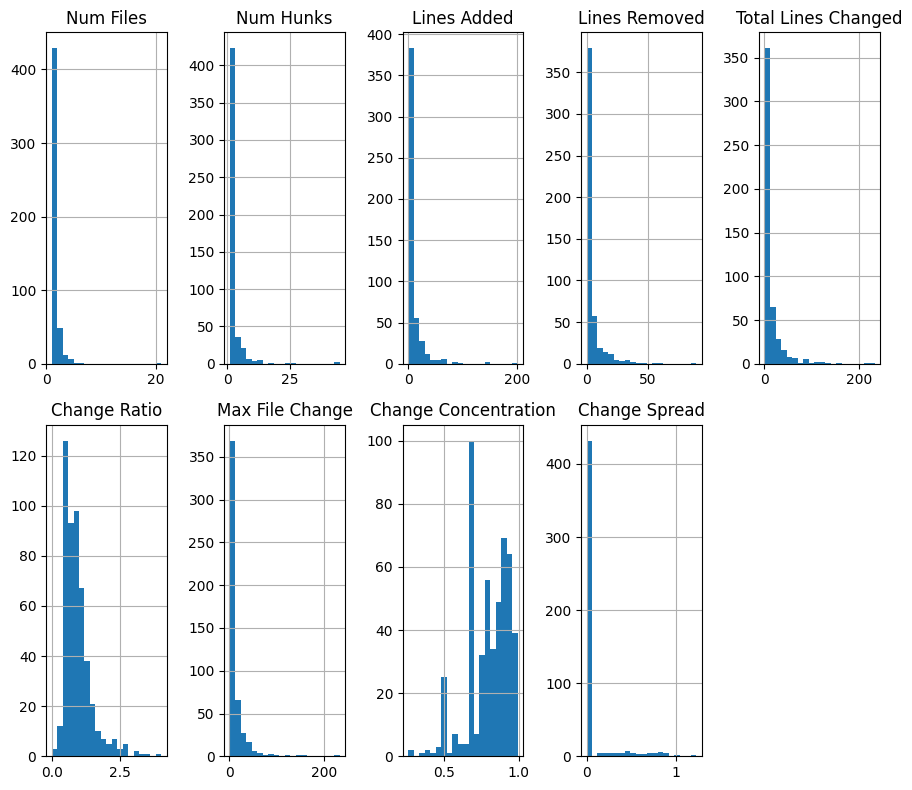

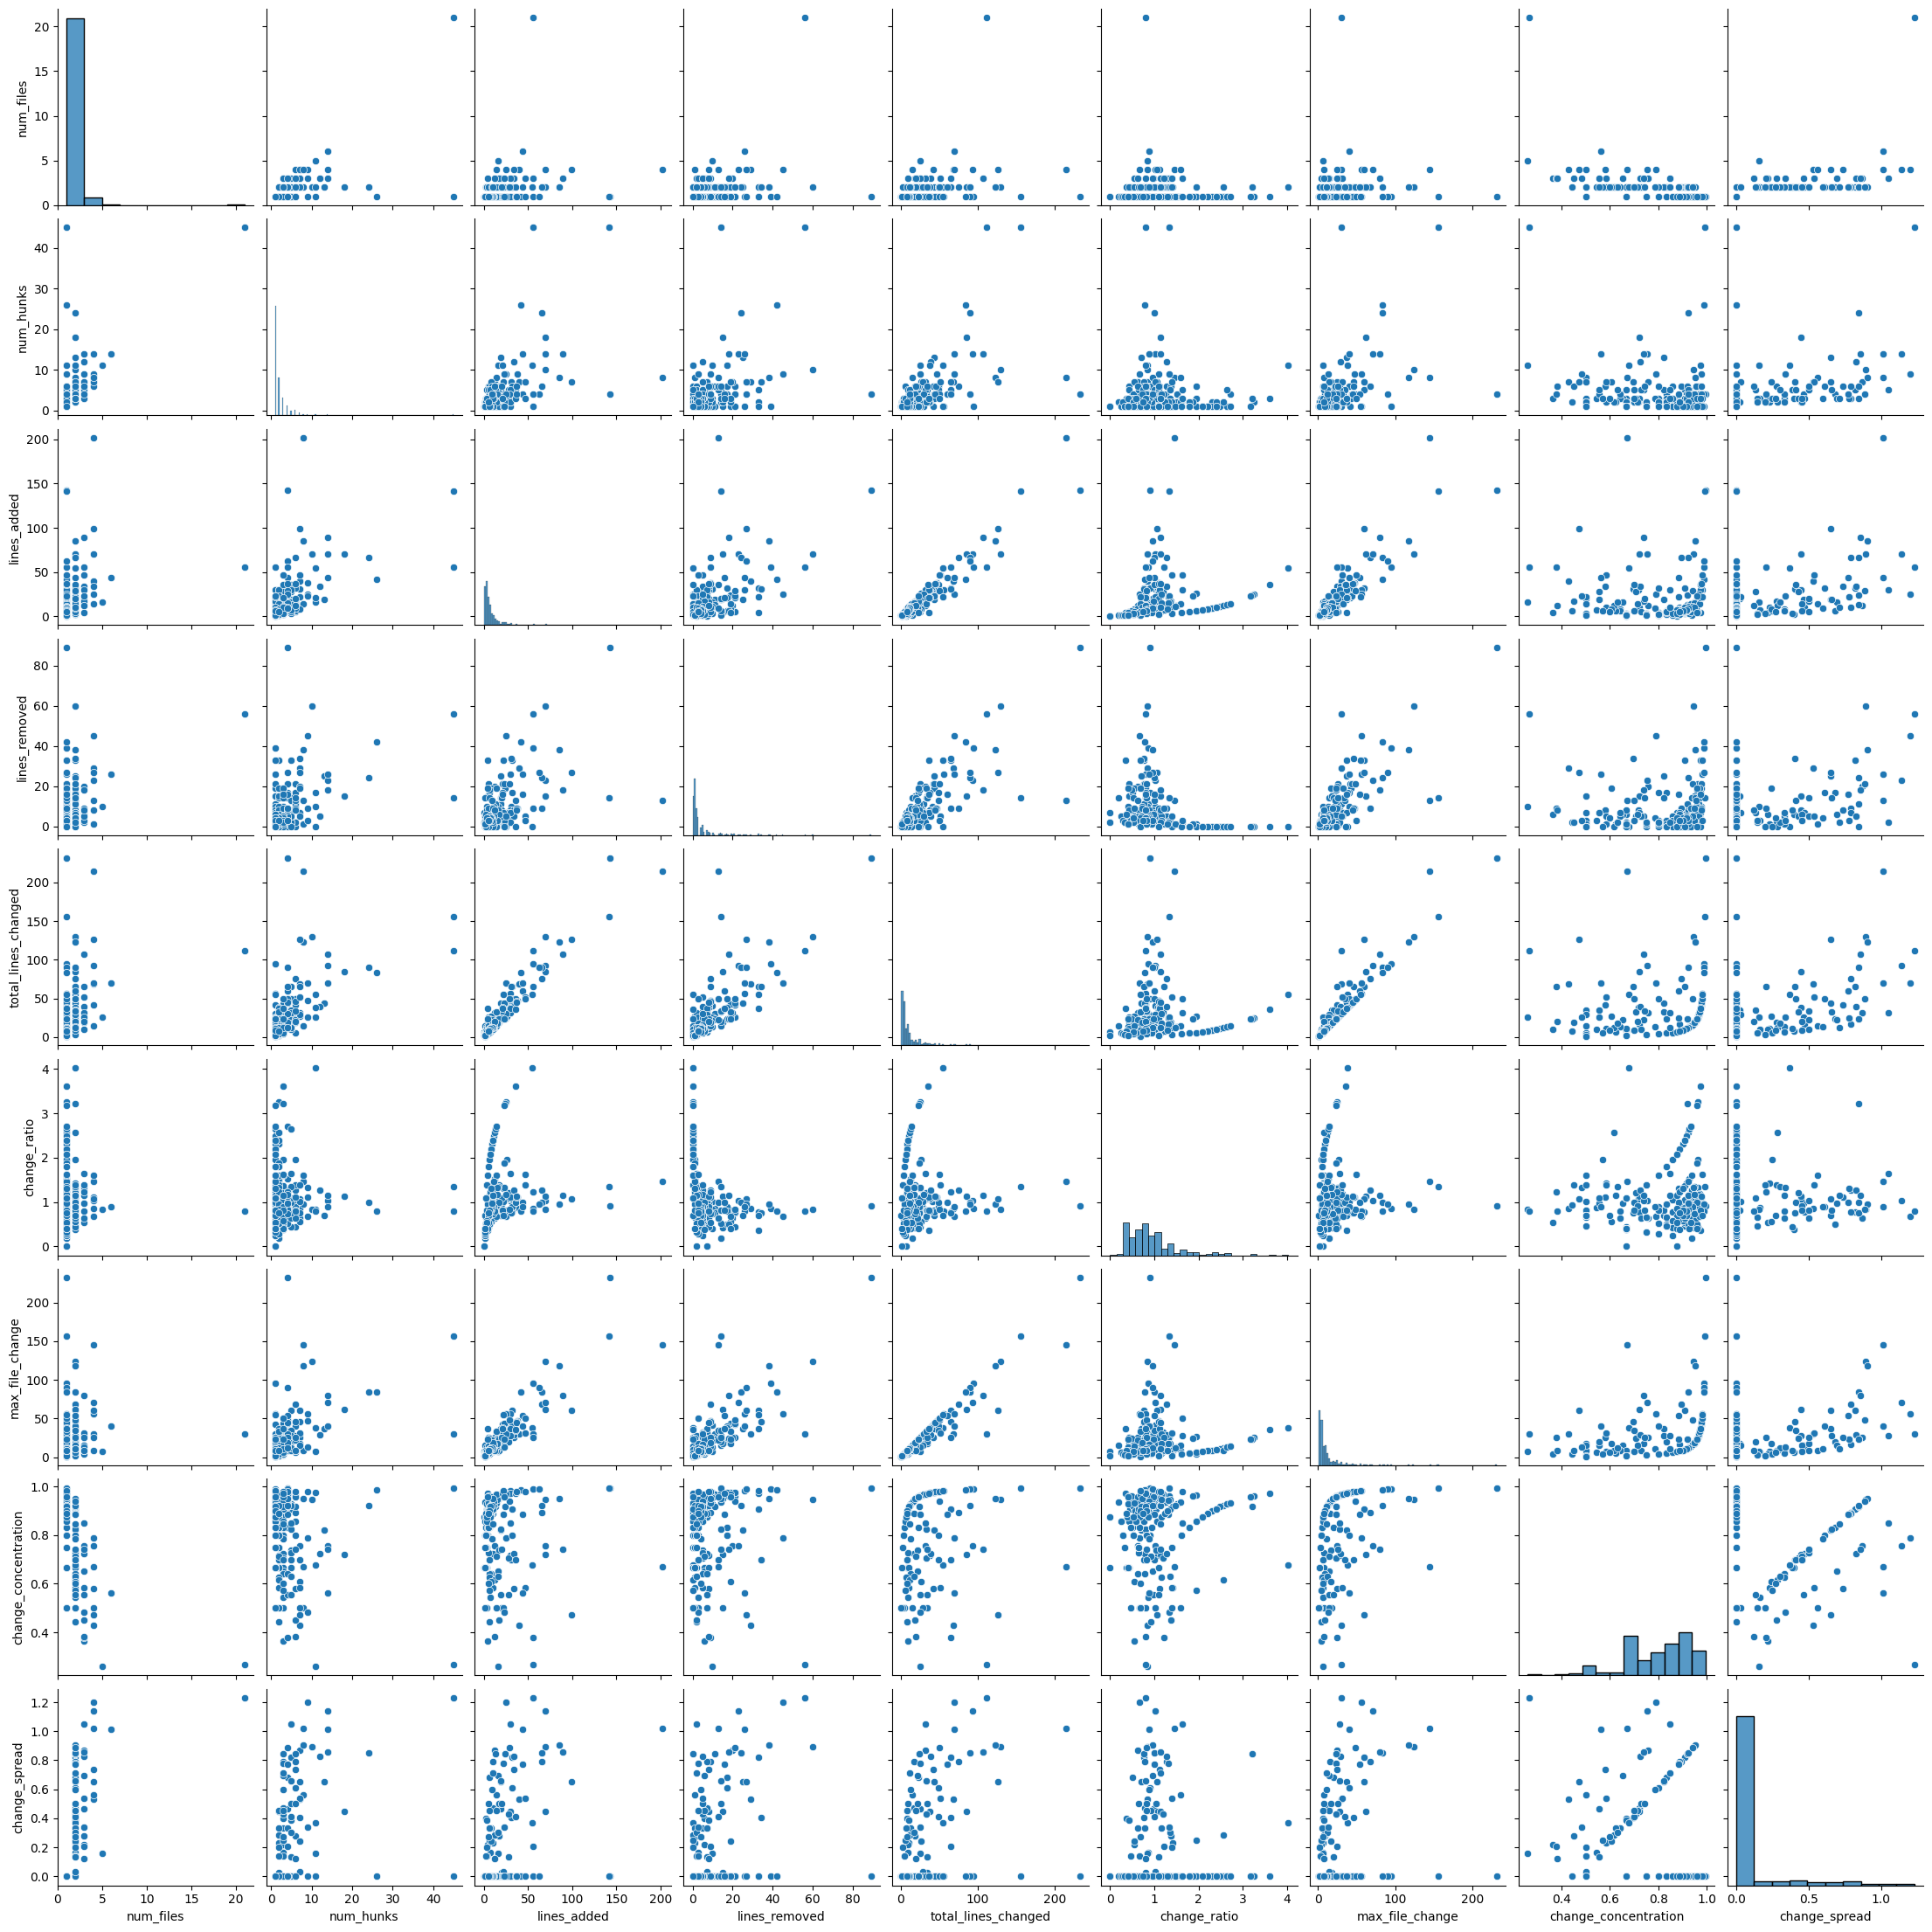

In [23]:
#Histograms of each feature

#Creating titles from column names
titles = [col.replace('_', ' ').title() for col in numerical_cols]

#Histograms
fig, axes = plt.subplots(2, 5, figsize=(9, 8))
axes_flat = axes.flatten()

for i, (col, title) in enumerate(zip(numerical_cols, titles)):
    df_cleaned[col].hist(bins=20, ax=axes_flat[i])
    axes_flat[i].set_title(title)

#Hiding the unused subplot
for i in range(len(numerical_cols), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()


sns.pairplot(df_cleaned[numerical_cols])

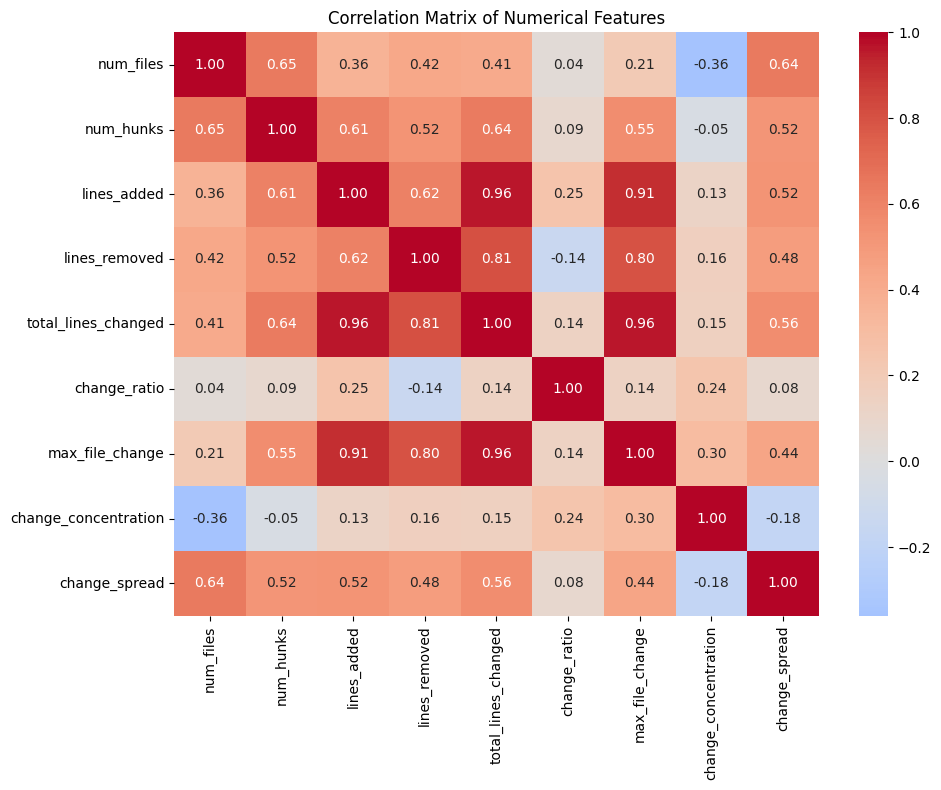



Normalised entropy (information content):
num_files: 0.2804
num_hunks: 0.5110
lines_added: 0.7567
lines_removed: 0.6541
total_lines_changed: 0.7777
change_ratio: 0.8504
max_file_change: 0.7722
change_concentration: 0.7418
change_spread: 0.2352


In [27]:
#Checking correlation between all numerical features to identify any feature redundancy

corr_matrix = df_cleaned[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


#Entropy analysis for feature selection
print("\n\nNormalised entropy (information content):")
for col in numerical_cols:
    value_counts = df_cleaned[col].value_counts()
    probs = value_counts / len(df_cleaned)
    ent = entropy(probs) / np.log(len(value_counts)) if len(value_counts) > 1 else 0
    print(f"{col}: {ent:.4f}")

In [28]:
#Full feature set
comprehensive_numerical_cols = [
    "num_files", "num_hunks", "lines_added", "lines_removed",
    "total_lines_changed", "change_ratio",
    "max_file_change", "change_concentration", "change_spread"
]

#Selected features for SWE-bench verified clustering
selected_numerical_cols = [
    "num_files",               # Multi-file changes (rare but important)
    "num_hunks",               # Complexity indicator
    "total_lines_changed",     # Overall patch size
    "change_ratio",            # Add/remove balance
    "max_file_change",         # Concentration of changes
    "change_concentration"     # How focused the changes are
]

In [29]:
#Dropping redundant features
cols_to_drop_lowentropy = ["lines_added"] + ["lines_removed"] + ["change_spread"] \

df_cleaned = df_cleaned.drop(columns = cols_to_drop_lowentropy)

In [30]:
df_cleaned.head(5)

,repo,patch,problem_statement,hints_text,FAIL_TO_PASS,PASS_TO_PASS,difficulty,underspecified,underspecified_notes,false_negative,false_negative_notes,num_files,num_hunks,total_lines_changed,change_ratio,max_file_change,change_concentration,difficulty_numeric
0,astropy/astropy,diff --git a/astropy/modeling/separable.py b/a...,Modeling's `separability_matrix` does not comp...,NaN,"[""astropy/modeling/tests/test_separable.py::te...","[""astropy/modeling/tests/test_separable.py::te...",15 min - 1 hour,1.0,"The issue description is clear, explaining tha...",0.0,The goal of the test patch is to evaluate nest...,1.0,1.0,2.0,0.409384,2.0,0.666667,1
1,astropy/astropy,diff --git a/astropy/timeseries/core.py b/astr...,TimeSeries: misleading exception when required...,The relevant code that produces the misleading...,"[""astropy/timeseries/tests/test_sampled.py::te...","[""astropy/timeseries/tests/test_sampled.py::te...",15 min - 1 hour,1.0,The issue's concern is well understood. The va...,1.0,The error message is raised is particular to t...,1.0,2.0,14.0,1.041324,14.0,0.933333,1
2,astropy/astropy,diff --git a/astropy/table/table.py b/astropy/...,Consider removing auto-transform of structured...,@mhvk - I'm happy to do this PR if you think i...,"[""astropy/table/tests/test_mixin.py::test_ndar...","[""astropy/table/tests/test_mixin.py::test_attr...",15 min - 1 hour,1.0,1. It is clearly suggested that automatic conv...,0.0,1. Issue description wants the agent to remove...,1.0,1.0,7.0,0.000000,7.0,0.875000,1
3,astropy/astropy,diff --git a/astropy/coordinates/builtin_frame...,A direct approach to ITRS to Observed transfor...,"cc @StuartLittlefair, @adrn, @eteq, @eerovaher...","[""astropy/coordinates/tests/test_intermediate_...","[""astropy/coordinates/tests/test_intermediate_...",1-4 hours,0.0,Issue description is well specified. It inform...,0.0,The tests are well scoped and cover all possib...,4.0,8.0,215.0,1.460050,145.0,0.671296,2
4,astropy/astropy,diff --git a/astropy/io/ascii/html.py b/astrop...,ASCII table output to HTML does not support su...,Welcome to Astropy 👋 and thank you for your fi...,"[""astropy/io/ascii/tests/test_html.py::test_wr...","[""astropy/io/ascii/tests/test_html.py::test_li...",15 min - 1 hour,0.0,The issue description is very clear and well-o...,0.0,The `test_write_table_formatted_columns` funct...,1.0,1.0,2.0,1.098612,2.0,0.666667,1


# Clustering

## Base-lining with K-Means!

In [31]:
#To use K-means, we first need to scale the features - why? K means is impacted by outliers
#scaling the numerical features pre clustering. Scaler = RobustScaler()
features = df_cleaned[["num_files", "num_hunks", "total_lines_changed", "change_ratio", "max_file_change","change_concentration"]]
Scaler = RobustScaler()
X_scaled = Scaler.fit_transform(features)

In [32]:
#K-means clustering applied to the main numerical features of pull request to serve as a baseline, picking 6 clusters

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 6, random_state= 42)
df_cleaned["cluster"] = kmeans.fit_predict(X_scaled)

In [33]:
#Creating cluster summaries
cluster_summary = df_cleaned.groupby("cluster").agg(
    cluster_size = ("cluster", "count"),
    num_files_mean=("num_files", "mean"),
    num_hunks_mean=("num_hunks", "mean"),
    total_lines_changed_mean=("total_lines_changed", "mean"),
    change_ratio_mean=("change_ratio", "mean"),
    max_file_change_mean=("max_file_change", "mean"),
    change_concentration_mean=("change_concentration", "mean")
).reset_index()

cluster_summary

,cluster,cluster_size,num_files_mean,num_hunks_mean,total_lines_changed_mean,change_ratio_mean,max_file_change_mean,change_concentration_mean
0,0,396,1.050505,1.383838,6.325758,0.888239,6.184343,0.786326
1,1,3,1.666667,22.666667,86.333333,0.972172,76.666667,0.877414
2,2,79,1.632911,4.303797,28.949367,1.112264,24.962025,0.832821
3,3,2,2.500000,6.000000,223.500000,1.181842,188.500000,0.833502
4,4,2,11.000000,45.000000,134.000000,1.070052,93.000000,0.629559
5,5,18,2.555556,9.000000,77.833333,1.108490,62.611111,0.794782


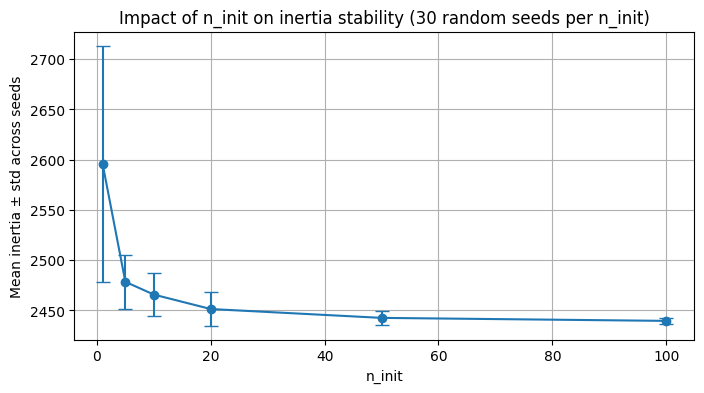

/tmp/ipython-input-50957982.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


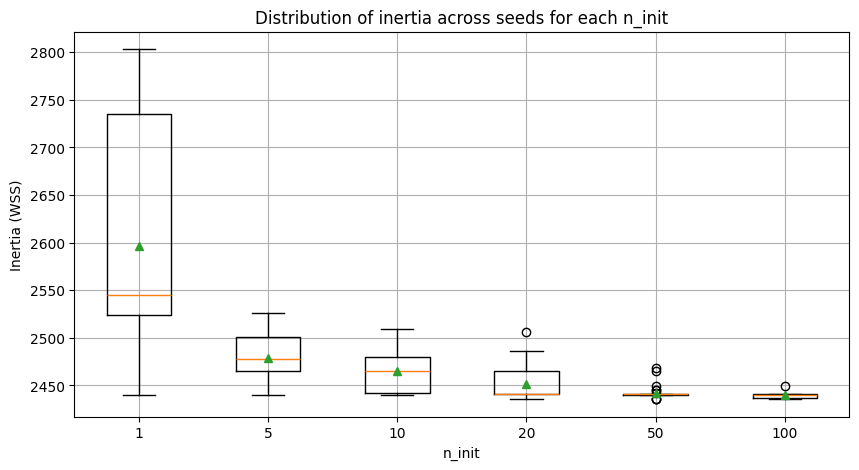

In [ ]:
#Code to check both the initialisations and the random seed
#parameters
n_inits = [1, 5, 10, 20, 50, 100]
n_seeds = 30

#lists to store the metrics
mean_inertia = []
std_inertia = []
all_inertias = {n: [] for n in n_inits}

#looping over n_init values
for n in n_inits:
    inertias = []
    for seed in range(n_seeds):
        kmeans = KMeans(
            n_clusters=6,
            n_init=n,
            random_state=seed
        )
        kmeans.fit(X_scaled)
        inertia = kmeans.inertia_
        inertias.append(inertia)
        all_inertias[n].append(inertia)
    mean_inertia.append(np.mean(inertias))
    std_inertia.append(np.std(inertias))

#plot 1:Mean ± Std
plt.figure(figsize=(8, 4))
plt.errorbar(n_inits, mean_inertia, yerr=std_inertia, fmt="-o", capsize=5)
plt.xlabel("n_init")
plt.ylabel("Mean inertia ± std across seeds")
plt.title("Impact of n_init on inertia stability (30 random seeds per n_init)")
plt.grid()
plt.show()

#plot 2:Boxplot of all inertia values
plt.figure(figsize=(10, 5))
plt.boxplot(
    [all_inertias[n] for n in n_inits],
    labels=n_inits,
    showmeans=True
)
plt.xlabel("n_init")
plt.ylabel("Inertia (WSS)")
plt.title("Distribution of inertia across seeds for each n_init")
plt.grid()
plt.show()


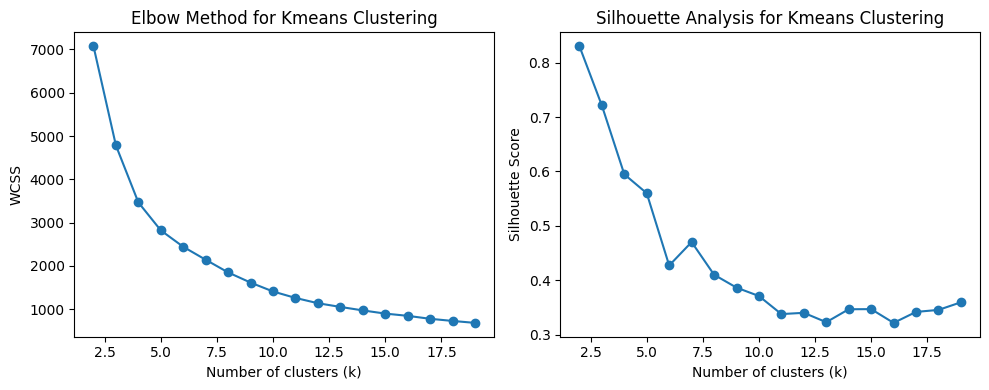

Silhouette scores: {2: np.float64(0.8301943087562185), 3: np.float64(0.7212339451026638), 4: np.float64(0.5948035352120343), 5: np.float64(0.5600369948183074), 6: np.float64(0.4272931812393187), 7: np.float64(0.470363886972954), 8: np.float64(0.4103413127111821), 9: np.float64(0.3866473765604479), 10: np.float64(0.3711920748697652), 11: np.float64(0.3380182718761111), 12: np.float64(0.34035202053223373), 13: np.float64(0.32311644776543685), 14: np.float64(0.34690552423103943), 15: np.float64(0.34712185351830444), 16: np.float64(0.32185106163109856), 17: np.float64(0.34201959371601587), 18: np.float64(0.34569351713454943), 19: np.float64(0.3596891806432787)}


In [34]:
#Elbow method with RobustScaler
wcss = []
k_range = range(2, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    kmeans.fit(X_scaled)  #uses RobustScaler version which i changed to after Standard Scaler gave poorer results
    wcss.append(kmeans.inertia_)

#silhouette analysis
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

#Elbow
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Kmeans Clustering')

#Silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Kmeans Clustering')

plt.tight_layout()
plt.show()

print("Silhouette scores:", dict(zip(k_range, silhouette_scores)))

## Linking Clusters to Difficulty (time spent) and Specification of the Patch (whether or not it is underspecified)

/tmp/ipython-input-1562870247.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  difficulty_counts = df_cleaned.groupby(['cluster', 'difficulty']).size().unstack().fillna(0)


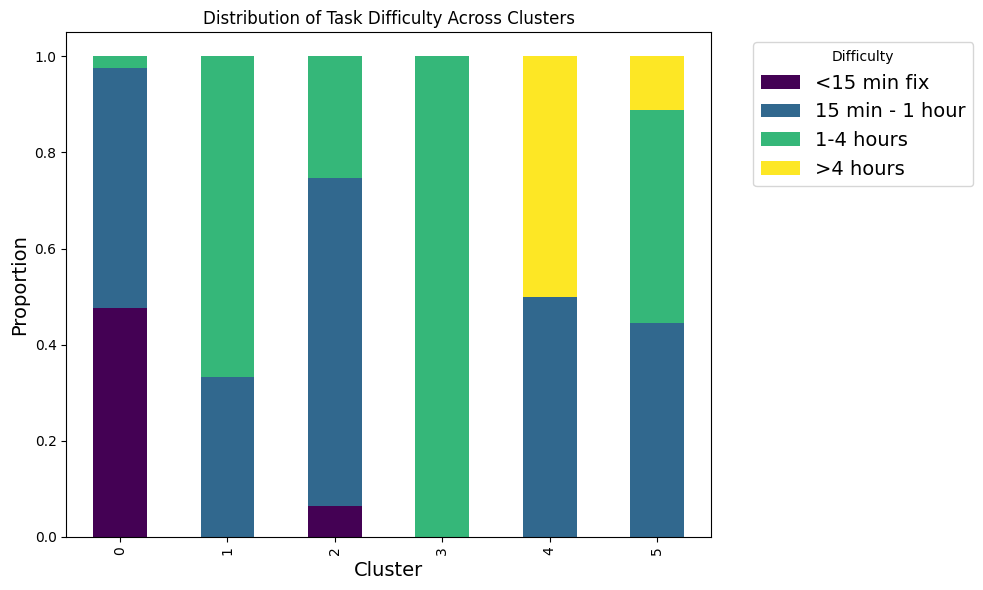

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

#count of difficulty levels per cluster
difficulty_counts = df_cleaned.groupby(['cluster', 'difficulty']).size().unstack().fillna(0)

#normalising to get percentage distribution
difficulty_percent = difficulty_counts.div(difficulty_counts.sum(axis=1), axis=0)


difficulty_percent.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

plt.title('Distribution of Task Difficulty Across Clusters')
plt.ylabel('Proportion',fontsize=14)
plt.xlabel('Cluster',fontsize=14)
plt.legend(title='Difficulty', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=14)
plt.tight_layout()
plt.show()


# Interpreting Cluster Difficulty



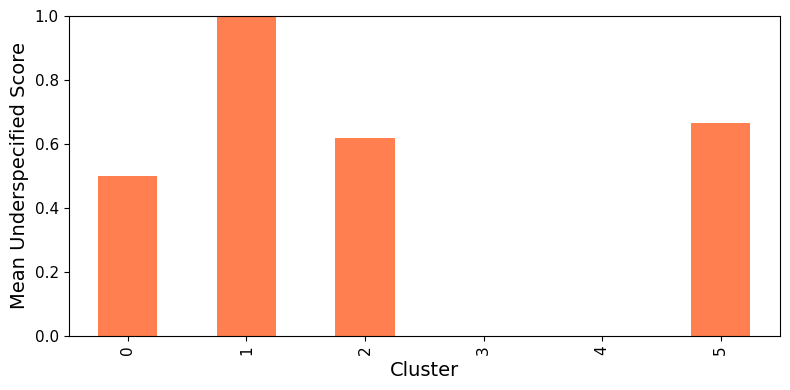

In [36]:
underspecified_rate = df_cleaned.groupby("cluster")["underspecified"].mean()

#plotting
underspecified_rate.plot(kind='bar', color='coral', figsize=(8, 4))
plt.title('Proportion of Underspecified Tasks by Cluster', fontsize=14)
plt.ylabel('Mean Underspecified Score', fontsize=14)
plt.xlabel('Cluster', fontsize=14)
plt.ylim(0, 1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


# Implication for Clustering
Because of this, structural features alone are insufficient to fully explain task complexity. Rather than treating difficulty and specification labels for evaluating the clusters, I will treat them as meaningful features of the task itself.

In the next section, I incorporate these features into the clustering process using a mixed-type algorithm (K-Prototypes), to explore whether combining structural and semantic signals yields more interpretable clusters.

# Clustering with K-Prototypes

In [37]:
pip install kmodes


In [38]:
#mapping difficulty to ordinal scale
difficulty_map = {
    "< 15 min": 1,
    "15 min - 1 hour": 2,
    "1 - 4 hours": 3,
    "> 4 hours": 4
}


In [42]:
from kmodes.kprototypes import KPrototypes

#features to copy
mixed_features = [
    "num_files",
    "num_hunks",
    "total_lines_changed",
    "change_ratio",
    "max_file_change",
    "change_concentration",
    "difficulty",
    "underspecified"
]
X = df_cleaned[mixed_features].copy()

#mapping difficulty to numeric scale
difficulty_ordering = {
    "<15 min fix": 0,
    "15 min - 1 hour": 1,
    "1-4 hours": 2,
    ">4 hours": 3
}

#creating difficulty_num in BOTH X and df_cleaned
X["difficulty_num"] = X["difficulty"].map(difficulty_ordering)
df_cleaned["difficulty_num"] = df_cleaned["difficulty"].map(difficulty_ordering)

#converting underspecified to string
X["underspecified"] = X["underspecified"].astype(str)

#dropping original difficulty
X = X.drop(columns=["difficulty"])
X = X[["num_files", "num_hunks", "total_lines_changed", "change_ratio", "max_file_change","change_concentration"]]

cat_cols_idx = [5]  #only underspecified is categorical

#K-Prototypes clustering
kproto = KPrototypes(n_clusters=6, random_state=42)
clusters = kproto.fit_predict(X, categorical=cat_cols_idx)

df_cleaned["kproto_cluster"] = clusters

#after clustering, fixing data types before aggregation
df_cleaned["kproto_cluster"] = df_cleaned["kproto_cluster"].astype(int)
df_cleaned["difficulty_num"] = pd.to_numeric(df_cleaned["difficulty_num"], errors='coerce')
df_cleaned["underspecified_numeric"] = pd.to_numeric(df_cleaned["underspecified"], errors='coerce')

#summary with corrected column names
cluster_summary1 = df_cleaned.groupby("kproto_cluster").agg(
    cluster_size=("kproto_cluster", "count"),
    num_files_mean=("num_files", "mean"),
    num_hunks_mean=("num_hunks", "mean"),
    total_lines_changed_mean=("total_lines_changed", "mean"),
    change_ratio_mean=("change_ratio", "mean"),
    max_file_change_mean=("max_file_change", "mean"),
    change_concentration_mean=("change_concentration", "mean"),
    difficulty_mean=("difficulty_num", "mean"),
    underspecified_mean=("underspecified_numeric", "mean")
).reset_index()


In [41]:
##creating a combined view

#adding method column
cluster_summary["method"] = "KMeans"
cluster_summary1["method"] = "KPrototypes"

#renaming cluster columns to align for concat
cluster_summary = cluster_summary.rename(columns={"cluster": "cluster"})
cluster_summary1 = cluster_summary1.rename(columns={"kproto_cluster": "cluster"})

#combine
combined_summary = pd.concat([cluster_summary, cluster_summary1], axis=0)


combined_summary = combined_summary[
    ["method", "cluster", "cluster_size", "num_files_mean", "num_hunks_mean",
     "total_lines_changed_mean", "change_ratio_mean", "max_file_change_mean", "change_concentration_mean","difficulty_mean", "underspecified_mean"]
]

combined_summary.sort_values(["method", "cluster"]).reset_index(drop=True)


,method,cluster,cluster_size,num_files_mean,num_hunks_mean,total_lines_changed_mean,change_ratio_mean,max_file_change_mean,change_concentration_mean,difficulty_mean,underspecified_mean
0,KMeans,0,396,1.050505,1.383838,6.325758,0.888239,6.184343,0.786326,NaN,NaN
1,KMeans,1,3,1.666667,22.666667,86.333333,0.972172,76.666667,0.877414,NaN,NaN
2,KMeans,2,79,1.632911,4.303797,28.949367,1.112264,24.962025,0.832821,NaN,NaN
3,KMeans,3,2,2.500000,6.000000,223.500000,1.181842,188.500000,0.833502,NaN,NaN
4,KMeans,4,2,11.000000,45.000000,134.000000,1.070052,93.000000,0.629559,NaN,NaN
5,KMeans,5,18,2.555556,9.000000,77.833333,1.108490,62.611111,0.794782,NaN,NaN
6,KPrototypes,0,276,1.036232,1.278986,3.659420,0.782300,3.572464,0.737076,0.460145,0.507246
7,KPrototypes,1,23,2.000000,5.695652,53.565217,1.078866,43.869565,0.824643,1.478261,0.434783
8,KPrototypes,2,3,2.000000,19.000000,201.000000,1.234027,177.666667,0.886878,2.333333,0.000000
9,KPrototypes,3,53,1.490566,3.886792,28.490566,1.115894,25.433962,0.870911,1.245283,0.660377
